In [1]:
import torch
import torchvision
import torch.nn as nn
from torch.autograd import Variable
from torchvision import datasets, transforms
from model.wideVAE import *
from pgd_attack import *
import torch.optim as optim
import argparse
import numpy as np
from util import *
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1"
# import argparse

# parser = argparse.ArgumentParser(description='PyTorch CIFAR10 VAE Training')
# parser.add_argument('--batch-size', type=int, default=200, metavar='N',
#                     help='input batch size for training (default: 128)')
# parser.add_argument('--test-batch-size', type=int, default=200, metavar='N',
#                     help='input batch size for testing (default: 128)')
# parser.add_argument('--x-dim', type=int, default=784)
# parser.add_argument('--hidden-dim', type=int, default=400)
# parser.add_argument('--latent-dim', type=int, default=200)
# parser.add_argument('--epochs', type=int, default=30)
# args = parser.parse_args()
torch.manual_seed(1)
torch.cuda.manual_seed(1)
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
])
transform_test = transforms.Compose([
    transforms.ToTensor(),
])
batch_size = 200
test_batch_size = 200
beta = 0.5
trainset = torchvision.datasets.CIFAR10(root='../data', train=True, download=True, transform=transform_train)
train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, **kwargs)
testset = torchvision.datasets.CIFAR10(root='../data', train=False, download=True, transform=transform_test)
test_loader = torch.utils.data.DataLoader(testset, batch_size=test_batch_size, shuffle=False, **kwargs)

def train(vae_model, c_model, data_loader, vae_optimizer, c_optimizer, epoch_num):
    vae_model.train()
    c_model.train()
    v_loss_sum = 0
    c_loss_sum = 0
    for batch_idx, (data, target) in enumerate(data_loader):
        #data = data.view(batch_size, x_dim)
        data, target = data.to(device), target.to(device)
        vae_optimizer.zero_grad()
        c_optimizer.zero_grad()
        x_hat, mean, log_v, x_ = vae_model(data)
        # x_cat = torch.cat((mean, log_v),1)
        logit = c_model(x_.detach())
        #logit = c_model(x_cat)
        v_loss, c_loss = loss_function(data, target, x_hat, mean, log_v, logit, beta)
        #print(loss)
        v_loss_sum += v_loss
        c_loss_sum += c_loss
        # if epoch_num % 2 == 1:
        if epoch_num <= 30:
            v_loss.backward()
            vae_optimizer.step()
            c_loss.backward()
        else:
            c_loss.backward()
            c_optimizer.step()
            v_loss.backward()
        
    return v_loss_sum, c_loss_sum

def test(vae_model, c_model):
    err_num = 0
    err_adv = 0
    c_model.eval()
    vae_model.eval()
    for data, target in test_loader:
        data, target = data.to(device), target.to(device)
        logit = model_pred(data, vae_model, c_model)
        err_num += (logit.data.max(1)[1] != target.data).float().sum()
        # x_adv = pgd(vae_model, c_model, data, target, 40, 0.3, 0.01)
        # m_adv, log_adv = testtime_update(vae_model, x_adv,learning_rate=args.testtime_lr, num=args.testtime_epochs)
        # x_cat_adv = torch.cat((m_adv, log_adv), 1)
        # logit_adv = c_model(x_cat_adv)
        # err_adv += (logit_adv.data.max(1)[1] != target.data).float().sum()
    print(len(test_loader.dataset))
    print(err_num)
    # print(err_adv)



Files already downloaded and verified
Files already downloaded and verified


In [2]:
def adjust_learning_rate(optimizer, epoch, lr):
    """decrease the learning rate"""
    lr_ = lr
    if epoch >= 80:
        lr_ = lr * 0.1
    if epoch >= 90:
        lr_ = lr * 0.01
    if epoch >= 100:
        lr_ = lr * 0.001
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr_
    

In [3]:

lr = 0.001
epochs = 90
vae_model = wide_VAE(zDim=256).to(device)
vae_optimizer = optim.Adam(vae_model.parameters(), lr=lr)
c_model = classifier().to(device)
c_optimizer = optim.Adam(c_model.parameters(), lr=lr*10)
print(len(train_loader.dataset))
for epoch in range(1, epochs+1):
    adjust_learning_rate(c_optimizer, epoch, lr*10)
    v_loss, c_loss = train(vae_model,c_model, train_loader, vae_optimizer, c_optimizer, epoch)
    print('Epoch {}: VAE Average loss: {:.6f}'.format(epoch, v_loss/len(train_loader.dataset)))
    print('Epoch {}: Classifier Average loss: {:.6f}'.format(epoch, c_loss/len(train_loader.dataset)))
test(vae_model, c_model)

50000


/home/hao/anaconda3/envs/test/lib/python3.7/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


Epoch 1: VAE Average loss: 1774.523438
Epoch 1: Classifier Average loss: 2.338953
Epoch 2: VAE Average loss: 1586.342896
Epoch 2: Classifier Average loss: 2.339547
Epoch 3: VAE Average loss: 1553.655151
Epoch 3: Classifier Average loss: 2.339198
Epoch 4: VAE Average loss: 1540.147217
Epoch 4: Classifier Average loss: 2.339128
Epoch 5: VAE Average loss: 1532.249512
Epoch 5: Classifier Average loss: 2.340662
Epoch 6: VAE Average loss: 1524.577881
Epoch 6: Classifier Average loss: 2.340745
Epoch 7: VAE Average loss: 1520.175781
Epoch 7: Classifier Average loss: 2.341443
Epoch 8: VAE Average loss: 1517.259644
Epoch 8: Classifier Average loss: 2.341225
Epoch 9: VAE Average loss: 1513.973511
Epoch 9: Classifier Average loss: 2.341274
Epoch 10: VAE Average loss: 1511.032959
Epoch 10: Classifier Average loss: 2.341641
Epoch 11: VAE Average loss: 1508.461426
Epoch 11: Classifier Average loss: 2.341399
Epoch 12: VAE Average loss: 1506.034546
Epoch 12: Classifier Average loss: 2.342533
Epoch 13: 

In [4]:
import matplotlib.pyplot as plt
def show_image(x, idx):
    x = x.view(test_batch_size,3, 32, 32)
    # x = x.detach().cpu().numpy()
    # x = x.transpose(0,2,3,1).astype("uint8")
    fig = plt.figure()
    plt.imshow(transforms.ToPILImage()(x[idx]))

In [4]:
def testtime_update(vae_model, x_adv, learning_rate=0.1, num = 20):
    x_hat_adv, mean, log_v= vae_model(x_adv)
    x_adv = x_adv.detach()
    for _ in range(num):
        loss = vae_loss(x_adv, x_hat_adv, mean, log_v)
        mean.retain_grad()
        log_v.retain_grad()
        loss.backward(retain_graph=True)
        with torch.no_grad():
            mean.data -= learning_rate * mean.grad.data
            log_v.data -= learning_rate * log_v.grad.data
        mean.grad.data.zero_()
        log_v.grad.data.zero_()
        x_hat_adv = vae_model.decoder(vae_model.reparameterize(mean, log_v))
    return mean, log_v

In [6]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
from torch.autograd import Variable
def pgd(vae_model, c_model, X, label, num_steps, epsilon, step_size):
    X_pgd = Variable(X.data, requires_grad=True)
    for _ in range(num_steps):
        opt = optim.SGD([X_pgd], lr=1e-3)
        opt.zero_grad()
        with torch.enable_grad():
            _, mean, log_v = vae_model(X_pgd)
            x_cat = torch.cat((mean, log_v), 1)
            logit = c_model(x_cat)
            loss = nn.CrossEntropyLoss()(logit, label)
        loss.backward()
        eta = step_size * X_pgd.grad.data.sign()
        X_pgd = Variable(X_pgd.data + eta, requires_grad=True)
        eta = torch.clamp(X_pgd.data - X.data, -epsilon, epsilon)
        X_pgd = Variable(X.data + eta, requires_grad=True)
        X_pgd = Variable(torch.clamp(X_pgd, 0, 1.0), requires_grad=True)
    return X_pgd

In [5]:
for data, target in test_loader:
    x, y = data.to(device), target.to(device)
    # x_adv = pgd(vae_model, c_model, x, y, 40, 0.3, 0.01)
    break
x_hat, _,_,_ = vae_model(x)
# x_hat_adv, mean, log_v = vae_model(x_adv)
# x_cat = torch.cat((mean, log_v), 1)
# logit = c_model(x_cat)
# print(logit.max(1)[1])

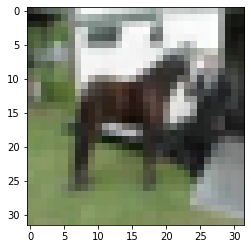

In [6]:
idex = 20
show_image(x, idx=idex)

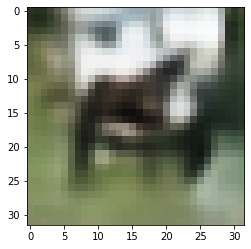

In [7]:
show_image(x_hat, idx=idex)

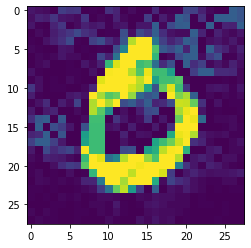

In [15]:
show_image(x_adv, idx=idex)

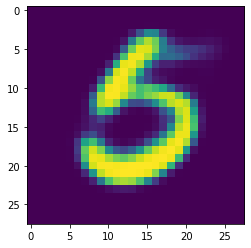

In [16]:
show_image(x_hat_adv, idx=idex)